# Lecture 13: Class demo

## Imports

In [109]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
sys.path.append(os.path.join(os.path.abspath("code")))
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
DATA_DIR = os.path.join("data/")
from sklearn.svm import SVC

<br><br><br><br>

### Feature interactions and feature crosses

- A **feature cross** is a synthetic feature formed by multiplying or crossing two or more features. 
- Example: 
Is the following dataset (XOR function) linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 1 | 1  | 0|
| -1 | 1  | 1|
| 1 | -1  | 1|
| -1 | -1  | 0|    


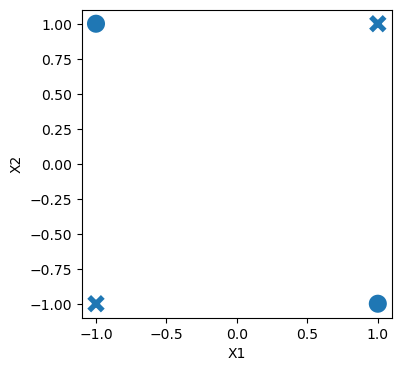

In [110]:
import seaborn as sb
X = np.array([
    [-1, -1],
    [1, -1],
    [-1, 1],
    [1, 1]
])
y = np.array([1, 0, 0, 1])
df = pd.DataFrame(np.column_stack([X, y]), columns=["X1", "X2", "target"])
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X1", y="X2", style="target", s=200, legend=False);

- For XOR like problems, if we create a feature cross $x1x2$, the data becomes linearly separable. 

| $$x_1$$ | $$x_2$$ | $$x_1x_2$$ | target|
|---------|---------|---------|---------|
| 1 | 1  | 1 | 0|
| -1 | 1  | -1 | 1|
| 1 | -1  | -1 | 1|
| -1 | -1  | 1 | 0|    

In [111]:
df["X1X2"] = df["X1"] * df["X2"]
df

,X1,X2,target,X1X2
0,-1,-1,1,1
1,1,-1,0,-1
2,-1,1,0,-1
3,1,1,1,1


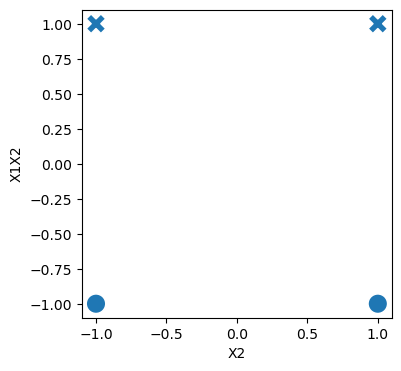

In [112]:
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X2", y="X1X2", style="target", s=200, legend=False);

Let's look at an example with more data points. 

In [113]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X_xor = rng.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# Interaction term
Z = X_xor[:, 0] * X_xor[:, 1]

In [114]:
df = pd.DataFrame({'X': X_xor[:, 0], 'Y': X_xor[:, 1], 'Z': Z, 'Class': y_xor})
df.head()

,X,Y,Z,Class
0,1.764052,0.400157,0.705898,False
1,0.978738,2.240893,2.193247,False
2,1.867558,-0.977278,-1.825123,True
3,0.950088,-0.151357,-0.143803,True
4,-0.103219,0.410599,-0.042382,True


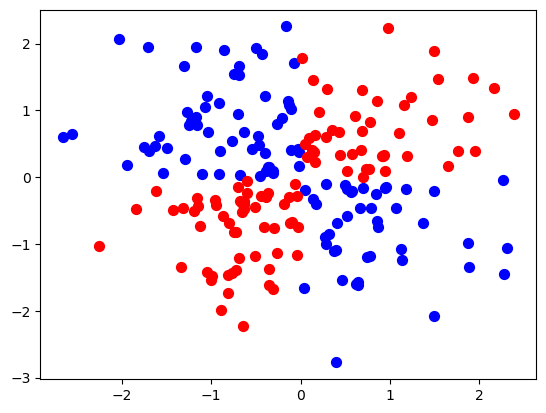

In [115]:
plt.scatter(df[df['Class'] == True]['X'], df[df['Class'] == True]['Y'], c='blue', label='Class 0', s=50)
plt.scatter(df[df['Class'] == False]['X'], df[df['Class'] == False]['Y'], c='red', label='Class 0', s=50);

In [116]:
# Create an interactive 3D scatter plot using plotly
import plotly.express as px
fig = px.scatter_3d(df, x='X', y='Y', z='Z', color='Class', color_continuous_scale=['blue', 'red'])
fig.show();

In [117]:
LogisticRegression().fit(X_xor, y_xor).score(X_xor, y_xor)

0.535

In [118]:
from sklearn.preprocessing import PolynomialFeatures
pipe_xor = make_pipeline(
    PolynomialFeatures(interaction_only=True, include_bias=False), LogisticRegression()
)
pipe_xor.fit(X_xor, y_xor)
pipe_xor.score(X_xor, y_xor)

0.995

In [119]:
feature_names = (
    pipe_xor.named_steps["polynomialfeatures"].get_feature_names_out().tolist()
)

In [120]:
transformed = pipe_xor.named_steps["polynomialfeatures"].transform(X_xor)

In [121]:
pd.DataFrame(
    pipe_xor.named_steps["logisticregression"].coef_.transpose(),
    index=feature_names,
    columns=["Feature coefficient"],
)

,Feature coefficient
x0,-0.028672
x1,0.129459
x0 x1,-5.086461


The interaction feature has the biggest coefficient! 

### Feature crosses for one-hot encoded features
- You can think of feature crosses of one-hot-features as logical conjunctions
- Suppose you want to predict whether you will find parking or not based on two features: 
    - area (possible categories: UBC campus and Rogers Arena)
    - time of the day (possible categories: 9am and 7pm)
- A feature cross in this case would create four new features: 
    - UBC campus and 9am
    - UBC campus and 7pm
    - Rogers Arena and 9am
    - Rogers Arena and 7pm. 
- The features UBC campus and 9am on their own are not that informative but the newly created feature UBC campus and 9am or Rogers Arena and 7pm would be quite informative.

- Coming up with the right combination of features requires some domain knowledge or careful examination of the data. 
- There is no easy way to support feature crosses in sklearn. 

<br><br>

### Demo of feature engineering with numeric features

- Remember the [California housing dataset](https://www.kaggle.com/datasets/camnugent/california-housing-prices) we used earlier in the course? 
- The prediction task is predicting `median_house_value` for a given property. 

In [122]:
housing_df = pd.read_csv(DATA_DIR + "/california_housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [123]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Suppose we decide to train `ridge` model on this dataset. 

- What would happen if you train a model without applying any transformation on the categorical features ocean_proximity? 
    - Error!! A linear model requires all features in a numeric form.  
- What would happen if we apply OHE on `ocean_proximity` but we do not scale the features?
    - No syntax error. But the model results are likely to be poor. 
- Do we need to apply any other transformations on this data?     

In this section, we will look into some common ways to do feature engineering for numeric or categorical features.  

In [124]:
train_df, test_df = train_test_split(housing_df, test_size=0.2, random_state=123)

We have total rooms and the number of households in the neighbourhood. How about creating rooms_per_household feature using this information? 

In [125]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

In [126]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,287500.0,INLAND,6.219512
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,271500.0,<1H OCEAN,5.951644
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,191700.0,<1H OCEAN,3.628032
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,219700.0,<1H OCEAN,5.126238
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,114000.0,<1H OCEAN,4.024390
...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264


Let's start simple. Imagine that we only three features: `longitude`, `latitude`, and our newly created `rooms_per_household` feature. 

In [127]:
X_train_housing = train_df[["latitude", "longitude", "rooms_per_household"]]
y_train_housing = train_df["median_house_value"]

In [128]:
from sklearn.compose import make_column_transformer

numeric_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor1 = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats)
)

In [129]:
lr_1 = make_pipeline(preprocessor1, Ridge())
pd.DataFrame(
    cross_validate(lr_1, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.009929,0.002482,0.280028,0.311769
1,0.004491,0.001850,0.325319,0.300464
2,0.003724,0.001803,0.317277,0.301952
3,0.003202,0.001303,0.316798,0.303004
4,0.003812,0.001259,0.260258,0.314840


- The scores are not great. 
- Let's look at the distribution of the longitude and latitude features. 

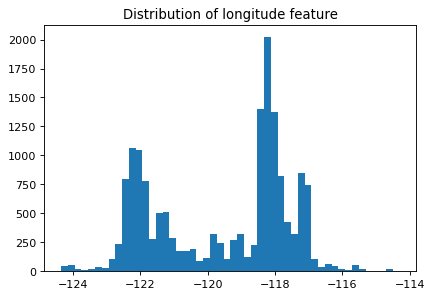

In [130]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["longitude"], bins=50)
plt.title("Distribution of longitude feature");

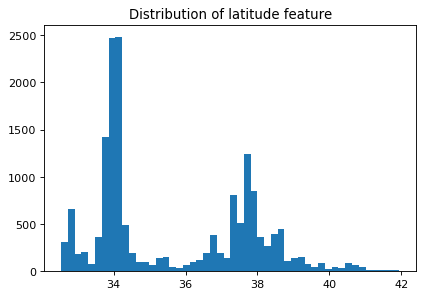

In [131]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["latitude"], bins=50)
plt.title("Distribution of latitude feature");

- Suppose you are planning to build a linear model for housing price prediction. 
- If we think longitude is a good feature for prediction, does it makes sense to use the floating point representation of this feature that's given to us?
- Remember that linear models can capture only linear relationships. 

- How about discretizing latitude and longitude features and putting them into buckets?
- This process of transforming numeric features into categorical features is called bucketing or binning. 
- In `sklearn` you can do this using `KBinsDiscretizer` transformer. 
- Let's examine whether we get better results with binning.

In [132]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude"]
numeric_feats = ["rooms_per_household"]

preprocessor2 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats),
)

In [133]:
lr_2 = make_pipeline(preprocessor2, Ridge())
pd.DataFrame(
    cross_validate(lr_2, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.020701,0.003721,0.441445,0.456419
1,0.011172,0.002719,0.469571,0.446216
2,0.011583,0.002852,0.479132,0.446869
3,0.011818,0.003013,0.450822,0.453367
4,0.011219,0.002940,0.388169,0.467628


The results are better with binned features. Let's examine how do these binned features look like. 

In [134]:
lr_2.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['rooms_per_household'])])),
                ('ridge', Ridge())])

In [135]:
pd.DataFrame(
    preprocessor2.fit_transform(X_train_housing).todense(),
    columns=preprocessor2.get_feature_names_out(),
)

,kbinsdiscretizer__latitude_0.0,kbinsdiscretizer__latitude_1.0,kbinsdiscretizer__latitude_2.0,kbinsdiscretizer__latitude_3.0,kbinsdiscretizer__latitude_4.0,kbinsdiscretizer__latitude_5.0,kbinsdiscretizer__latitude_6.0,kbinsdiscretizer__latitude_7.0,kbinsdiscretizer__latitude_8.0,kbinsdiscretizer__latitude_9.0,...,kbinsdiscretizer__longitude_11.0,kbinsdiscretizer__longitude_12.0,kbinsdiscretizer__longitude_13.0,kbinsdiscretizer__longitude_14.0,kbinsdiscretizer__longitude_15.0,kbinsdiscretizer__longitude_16.0,kbinsdiscretizer__longitude_17.0,kbinsdiscretizer__longitude_18.0,kbinsdiscretizer__longitude_19.0,pipeline__rooms_per_household
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316164
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209903
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711852
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.117528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.554621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064307
16508,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.235706
16509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212581
16510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.271037


How about discretizing all three features? 

In [136]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor3 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
)

In [137]:
lr_3 = make_pipeline(preprocessor3, Ridge())
pd.DataFrame(
    cross_validate(lr_3, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.013226,0.002626,0.590618,0.571969
1,0.010568,0.002690,0.575907,0.570473
2,0.010524,0.002198,0.579091,0.573542
3,0.009933,0.002392,0.571500,0.574260
4,0.009869,0.002191,0.541488,0.581687


- The results have improved further!! 
- Let's examine the coefficients

In [138]:
lr_3.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude',
                                                   'rooms_per_household'])])),
                ('ridge', Ridge())])

In [139]:
feature_names = (
    lr_3.named_steps["columntransformer"]
    .named_transformers_["kbinsdiscretizer"]
    .get_feature_names_out()
)

In [140]:
lr_3.named_steps["ridge"].coef_.shape

(60,)

In [141]:
coefs_df = pd.DataFrame(
    lr_3.named_steps["ridge"].coef_.transpose(),
    index=feature_names,
    columns=["coefficient"],
).sort_values("coefficient", ascending=False)
coefs_df.head

<bound method NDFrame.head of                             coefficient
longitude_1.0             211343.036136
latitude_1.0              205059.296601
latitude_0.0              201862.534342
longitude_0.0             190319.721818
longitude_2.0             160282.191204
longitude_3.0             157234.920305
latitude_2.0              154105.963689
rooms_per_household_19.0  138503.477291
latitude_8.0              135299.516394
longitude_4.0             132292.924485
latitude_7.0              124982.236174
latitude_3.0              118563.786115
longitude_5.0             116145.526596
rooms_per_household_18.0  102044.252042
longitude_6.0              96554.525554
latitude_4.0               92809.389349
latitude_6.0               90982.951669
latitude_9.0               71096.652487
rooms_per_household_17.0   70472.564483
latitude_5.0               69411.023366
longitude_10.0             52398.892961
rooms_per_household_16.0   44311.362553
rooms_per_household_15.0   31454.877046
longitude_

- Does it make sense to take feature crosses in this context?
- What information would they encode? 

<br><br>

Check out [apeendixA](appendixA_feature-engineering-text-data.ipynb) for a demo of feature engineering on text data. 

### Interim summary 

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem.
- For numeric data, some common operations to create new features are: 
    - Discretization: Converting continuous data into discrete buckets. For example, age could be split into categories like 0-20, 21-40, etc. to learn non-linear relationships 
    - Interaction Features: Creating new features by combining two or more existing features. 
- In the context of text data, if we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this, especially in the context of text and images, has moved to deep learning.
- Despite the rise of deep learning, many industries still rely on manual feature engineering. 

<br><br>

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    

<br><br><br><br>

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at two automatic feature selection methods from `sklearn`: 
    - Model-based selection 
    - Recursive feature elimination
    - Forward/backward selection 
- Very related to looking at feature importances.

In [142]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0, test_size=0.5
)

In [143]:
X_train.shape

(284, 30)

In [144]:
pipe_lr_all_feats = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr_all_feats.fit(X_train, y_train)
pd.DataFrame(
    cross_validate(pipe_lr_all_feats, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.003032
score_time     0.000565
test_score     0.968233
train_score    0.987681
dtype: float64

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important once. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with threahold "median" of feature importances. 
- Approximately how many features will be selected? 

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    threshold="median"
)

Can we use KNN to select features?

In [146]:
from sklearn.neighbors import KNeighborsClassifier
select_knn = SelectFromModel(
    KNeighborsClassifier(), 
    threshold="median"
)

pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_knn, LogisticRegression(max_iter=1000)
)

#pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)#
#).mean()

**No** KNN won't work since it does not report feature importances.

What about SVC?

In [147]:
select_svc = SelectFromModel(
    SVC(), threshold="median"
)

# pipe_lr_model_based = make_pipeline(
#     StandardScaler(), select_svc, LogisticRegression(max_iter=1000)
# )

# pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
# ).mean()

Only with a linear kernel but not with RBF kernel

We can put the feature selection transformer in a pipeline. 

In [148]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.085858
score_time     0.005908
test_score     0.950564
train_score    0.974480
dtype: float64

In [149]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.093475
score_time     0.006300
test_score     0.950564
train_score    0.974480
dtype: float64

In [150]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train).shape

(284, 15)

Similar results with only 15 features instead of 30 features. 

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, discard the least important feature according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

In [151]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [152]:
from sklearn.feature_selection import RFE

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [153]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [154]:
print("selected features: ", cancer.feature_names[rfe.support_])

selected features:  ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features. 

In [155]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print(rfe_cv.support_)
print(cancer.feature_names[rfe_cv.support_])

[False  True False  True False False  True  True  True False  True False
  True  True False  True False False False  True  True  True  True  True
 False False  True  True False  True]
['mean texture' 'mean area' 'mean concavity' 'mean concave points'
 'mean symmetry' 'radius error' 'perimeter error' 'area error'
 'compactness error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst concavity'
 'worst concave points' 'worst fractal dimension']


In [156]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.678127
score_time     0.003067
test_score     0.943609
train_score    1.000000
dtype: float64

- Slow because there is cross validation within cross validation 
- Not a big improvement in scores compared to all features on this toy case

<br><br>

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

























### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.